# Differential Expression Analysis with PyDESeq2

This notebook performs differential expression analysis on RNA-seq data using PyDESeq2.

## 1. Import Required Libraries

In [21]:
import pandas as pd
import numpy as np
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import warnings
warnings.filterwarnings('ignore')

## Configuration

Edit the variables below to change the inputs, groups, and output filenames without modifying the rest of the notebook.

The output CSV files will be automatically named in the format: `diseaseType_groupA_vs_groupB.csv`

For example: `lung_adenocarcinoma_vs_squamous_cell_carcinoma.csv`


In [ ]:
# --- User-facing configuration (non-technical users can edit these) ---
# Disease type (e.g., 'Lung', 'Breast', 'Colon')
DISEASE_TYPE = 'Lung'

# Column in the clinical file to use for grouping (e.g., 'DISEASE' or 'VITAL_STATUS')
CATEGORY_COLUMN = 'DISEASE'

# Exact group names to compare (must match values in the clinical file)
GROUP_A = 'Adenocarcinoma'      # treated as numerator in the contrast
GROUP_B = 'Squamous cell carcinoma'  # treated as denominator/reference

# Input files (relative to the notebook directory)
RNA_FILE = 'data_rna.txt'
CLINICAL_FILE = 'data_clinical_patient.txt'

# Output filenames (automatically formatted as: diseaseType_groupA_vs_groupB.csv)
disease_type_formatted = DISEASE_TYPE.lower().replace(' ', '_')
group_a_formatted = GROUP_A.lower().replace(' ', '_')
group_b_formatted = GROUP_B.lower().replace(' ', '_')

OUTPUT_FULL = f"{disease_type_formatted}_{group_a_formatted}_vs_{group_b_formatted}.csv"
OUTPUT_SIG = f"{disease_type_formatted}_{group_a_formatted}_vs_{group_b_formatted}_significant.csv"
VOLCANO_PLOT = 'volcano_plot.png'

# Other options
REFIT_COOKS = True

# Small summary so users can verify configuration at a glance
print('Configuration:')
print(f"DISEASE_TYPE = {DISEASE_TYPE}")
print(f"CATEGORY_COLUMN = {CATEGORY_COLUMN}")
print(f"GROUP_A = {GROUP_A}")
print(f"GROUP_B = {GROUP_B}")
print(f"RNA_FILE = {RNA_FILE}")
print(f"CLINICAL_FILE = {CLINICAL_FILE}")
print(f"OUTPUT_FULL = {OUTPUT_FULL}")
print(f"OUTPUT_SIG = {OUTPUT_SIG}")


Configuration:
CATEGORY_COLUMN = DISEASE
GROUP_A = Adenocarcinoma
GROUP_B = Squamous cell carcinoma
RNA_FILE = data_rna.txt
CLINICAL_FILE = data_clinical_patient.txt
OUTPUT_FULL = deseq2_results_full_adenocarcinoma_vs_squamous_cell_carcinoma.csv
OUTPUT_SIG = deseq2_results_significant_adenocarcinoma_vs_squamous_cell_carcinoma.csv


## 2. Load Data

Load the RNA expression data and clinical data.

In [23]:
# Load RNA expression data
print("Loading RNA expression data...")
rna_data = pd.read_csv(RNA_FILE, sep='\t', comment='#')

# Display first few rows
print(f"RNA data shape: {rna_data.shape}")
print("\nFirst few rows:")
rna_data.head()

Loading RNA expression data...
RNA data shape: (18787, 1038)

First few rows:
RNA data shape: (18787, 1038)

First few rows:


,Unnamed: 0,TCGA-05-4244-01A-01R-1107-07,TCGA-05-4249-01A-01R-1107-07,TCGA-05-4250-01A-01R-1107-07,TCGA-05-4382-01A-01R-1206-07,TCGA-05-4384-01A-01R-1755-07,TCGA-05-4389-01A-01R-1206-07,TCGA-05-4390-01A-02R-1755-07,TCGA-05-4395-01A-01R-1206-07,TCGA-05-4396-01A-21R-1858-07,...,TCGA-NK-A7XE-01A-12R-A405-07,TCGA-O1-A52J-01A-11R-A262-07,TCGA-O2-A52N-01A-11R-A26W-07,TCGA-O2-A52Q-01A-11R-A26W-07,TCGA-O2-A52S-01A-11R-A262-07,TCGA-O2-A52V-01A-31R-A262-07,TCGA-O2-A52W-01A-11R-A26W-07,TCGA-O2-A5IB-01A-11R-A27Q-07,TCGA-S2-AA1A-01A-12R-A39D-07,TCGA-XC-AA0X-01A-32R-A405-07
0,OR4F5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,SAMD11,1.43,1.78,1.26,3.04,2.57,1.29,1.36,0.91,2.44,...,1.00,2.80,2.90,1.41,1.08,1.34,0.81,3.68,3.58,1.85
2,NOC2L,5.52,6.16,6.09,6.08,6.49,5.86,6.26,6.54,5.98,...,6.78,6.76,6.87,6.13,7.01,7.33,6.76,7.91,6.18,7.05
3,KLHL17,4.66,5.27,4.34,4.89,5.14,3.46,4.59,4.19,4.59,...,4.86,4.48,6.09,5.71,5.12,5.44,5.44,6.07,5.11,5.00
4,PLEKHN1,3.32,2.82,3.42,3.32,4.46,2.14,2.24,3.25,2.53,...,3.19,3.12,5.50,4.89,2.29,4.20,3.23,2.35,2.88,5.20


In [24]:
# Load clinical data
print("Loading clinical data...")
clinical_data = pd.read_csv(CLINICAL_FILE, sep='\t', comment='#')

print(f"Clinical data shape: {clinical_data.shape}")
print("\nFirst few rows:")
clinical_data.head()

Loading clinical data...
Clinical data shape: (1037, 15)

First few rows:


,PATIENT_ID,DATASET,DISEASE,GRADE,STAGE,GENDER,AGE,VITAL_STATUS,DRUG_THERAPY_NAME,DRUG_THERAPY_TYPE,PRIMARY_THERAPY_OUTCOME_SUCCESS,DAYS_TO_LAST_FOLLOW_UP,DAYS_TO_DEATH,SMOKING.STATUS,BATCH
0,TCGA-05-4244-01A-01R-1107-07,tcga_luad,Adenocarcinoma,IV,0,male,na,alive,na,na,na,0,na,na,tcga
1,TCGA-05-4249-01A-01R-1107-07,tcga_luad,Adenocarcinoma,I,0,male,na,alive,na,na,na,1523,na,Current reformed smoker for > 15 years,tcga
2,TCGA-05-4250-01A-01R-1107-07,tcga_luad,Adenocarcinoma,III,0,female,na,dead,na,na,na,na,121,na,tcga
3,TCGA-05-4382-01A-01R-1206-07,tcga_luad,Adenocarcinoma,I,0,male,na,alive,na,na,na,607,na,Current reformed smoker for < or = 15 years,tcga
4,TCGA-05-4384-01A-01R-1755-07,tcga_luad,Adenocarcinoma,III,0,male,na,alive,Cisplatin,Chemotherapy,na,426,na,Current reformed smoker for > 15 years,tcga


## 3. Prepare Data for PyDESeq2

PyDESeq2 requires:
- A counts matrix (genes as rows, samples as columns)
- A metadata dataframe with sample information

In [25]:
# Prepare counts matrix
# Assuming first column contains gene identifiers and rest are sample counts
gene_col = rna_data.columns[0]
counts = rna_data.set_index(gene_col)

# Convert to numeric, handling any non-numeric values
counts = counts.apply(pd.to_numeric, errors='coerce')

# Remove rows with all NaN values
counts = counts.dropna(how='all')

# Fill remaining NaN with 0 and convert to integers
counts = counts.fillna(0).astype(int)

print(f"Counts matrix shape: {counts.shape}")
print(f"Genes: {counts.shape[0]}, Samples: {counts.shape[1]}")
counts.head()

Counts matrix shape: (18787, 1037)
Genes: 18787, Samples: 1037


,TCGA-05-4244-01A-01R-1107-07,TCGA-05-4249-01A-01R-1107-07,TCGA-05-4250-01A-01R-1107-07,TCGA-05-4382-01A-01R-1206-07,TCGA-05-4384-01A-01R-1755-07,TCGA-05-4389-01A-01R-1206-07,TCGA-05-4390-01A-02R-1755-07,TCGA-05-4395-01A-01R-1206-07,TCGA-05-4396-01A-21R-1858-07,TCGA-05-4397-01A-01R-1206-07,...,TCGA-NK-A7XE-01A-12R-A405-07,TCGA-O1-A52J-01A-11R-A262-07,TCGA-O2-A52N-01A-11R-A26W-07,TCGA-O2-A52Q-01A-11R-A26W-07,TCGA-O2-A52S-01A-11R-A262-07,TCGA-O2-A52V-01A-31R-A262-07,TCGA-O2-A52W-01A-11R-A26W-07,TCGA-O2-A5IB-01A-11R-A27Q-07,TCGA-S2-AA1A-01A-12R-A39D-07,TCGA-XC-AA0X-01A-32R-A405-07
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
OR4F5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SAMD11,1,1,1,3,2,1,1,0,2,0,...,1,2,2,1,1,1,0,3,3,1
NOC2L,5,6,6,6,6,5,6,6,5,5,...,6,6,6,6,7,7,6,7,6,7
KLHL17,4,5,4,4,5,3,4,4,4,4,...,4,4,6,5,5,5,5,6,5,5
PLEKHN1,3,2,3,3,4,2,2,3,2,2,...,3,3,5,4,2,4,3,2,2,5


In [26]:
# Prepare metadata
# Match sample IDs between RNA data and clinical data
sample_ids = counts.columns.tolist()

# Create a simple metadata DataFrame
# Use the configured category column for the condition (e.g., 'DISEASE')
metadata = clinical_data[clinical_data['PATIENT_ID'].isin(sample_ids)].copy()
metadata = metadata.set_index('PATIENT_ID')
metadata = metadata.loc[sample_ids]  # Ensure order matches counts matrix

# Select condition column from the configured CATEGORY_COLUMN and clean values
metadata['condition'] = metadata[CATEGORY_COLUMN].fillna('unknown')

print(f"Metadata shape: {metadata.shape}")
print("\nCondition distribution:")
print(metadata['condition'].value_counts())
metadata.head()

Metadata shape: (1037, 15)

Condition distribution:
condition
Adenocarcinoma             535
Squamous cell carcinoma    502
Name: count, dtype: int64


,DATASET,DISEASE,GRADE,STAGE,GENDER,AGE,VITAL_STATUS,DRUG_THERAPY_NAME,DRUG_THERAPY_TYPE,PRIMARY_THERAPY_OUTCOME_SUCCESS,DAYS_TO_LAST_FOLLOW_UP,DAYS_TO_DEATH,SMOKING.STATUS,BATCH,condition
PATIENT_ID,,,,,,,,,,,,,,,
TCGA-05-4244-01A-01R-1107-07,tcga_luad,Adenocarcinoma,IV,0,male,na,alive,na,na,na,0,na,na,tcga,Adenocarcinoma
TCGA-05-4249-01A-01R-1107-07,tcga_luad,Adenocarcinoma,I,0,male,na,alive,na,na,na,1523,na,Current reformed smoker for > 15 years,tcga,Adenocarcinoma
TCGA-05-4250-01A-01R-1107-07,tcga_luad,Adenocarcinoma,III,0,female,na,dead,na,na,na,na,121,na,tcga,Adenocarcinoma
TCGA-05-4382-01A-01R-1206-07,tcga_luad,Adenocarcinoma,I,0,male,na,alive,na,na,na,607,na,Current reformed smoker for < or = 15 years,tcga,Adenocarcinoma
TCGA-05-4384-01A-01R-1755-07,tcga_luad,Adenocarcinoma,III,0,male,na,alive,Cisplatin,Chemotherapy,na,426,na,Current reformed smoker for > 15 years,tcga,Adenocarcinoma


## 4. Filter Data

Filter samples to include only those with valid conditions (alive vs dead).

In [27]:
# Keep only samples matching the two groups configured by the user
valid_samples = metadata[metadata['condition'].isin([GROUP_A, GROUP_B])].index

# Filter counts and metadata to the selected disease samples
counts_filtered = counts[valid_samples]
metadata_filtered = metadata.loc[valid_samples, ['condition']]

print(f"Filtered counts shape: {counts_filtered.shape}")
print(f"Filtered metadata shape: {metadata_filtered.shape}")
print("\nCondition distribution after filtering:")
print(metadata_filtered['condition'].value_counts())

Filtered counts shape: (18787, 1037)
Filtered metadata shape: (1037, 1)

Condition distribution after filtering:
condition
Adenocarcinoma             535
Squamous cell carcinoma    502
Name: count, dtype: int64


## 5. Create DESeq2 Dataset

In [28]:
# Create DESeq2 dataset
print("Creating DESeq2 dataset...")
# PyDESeq2 expects samples as rows and genes as columns, so we need to transpose
dds = DeseqDataSet(
    counts=counts_filtered.T,  # Transpose: samples as rows, genes as columns
    metadata=metadata_filtered,
    design_factors="condition",
    refit_cooks=REFIT_COOKS
)

print("DESeq2 dataset created successfully!")

Creating DESeq2 dataset...
DESeq2 dataset created successfully!


## 6. Run DESeq2 Analysis

In [29]:
# Run DESeq2 analysis
print("Running DESeq2 analysis...")
dds.deseq2()
print("DESeq2 analysis complete!")

Running DESeq2 analysis...
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 1.72 seconds.

... done in 1.72 seconds.

Fitting dispersions...
Fitting dispersions...
... done in 28.69 seconds.

Fitting dispersion trend curve...
... done in 28.69 seconds.

Fitting dispersion trend curve...
... done in 0.51 seconds.

Fitting MAP dispersions...
... done in 0.51 seconds.

Fitting MAP dispersions...
... done in 28.45 seconds.

Fitting LFCs...
... done in 28.45 seconds.

Fitting LFCs...
... done in 9.05 seconds.

Calculating cook's distance...
... done in 9.05 seconds.

Calculating cook's distance...
... done in 7.01 seconds.

Replacing 0 outlier genes.

... done in 7.01 seconds.

Replacing 0 outlier genes.



DESeq2 analysis complete!


## 7. Statistical Testing

In [30]:
# Perform statistical testing
print("Performing statistical tests...")
# Contrast: compare the two groups configured by the user
stat_res = DeseqStats(dds, contrast=['condition', GROUP_A, GROUP_B])
stat_res.summary()
print("Statistical testing complete!")

Performing statistical tests...


Running Wald tests...


Log2 fold change & Wald test p-value: condition Adenocarcinoma vs Squamous cell carcinoma
            baseMean  log2FoldChange     lfcSE      stat        pvalue  \
Unnamed: 0                                                               
OR4F5       0.000000             NaN       NaN       NaN           NaN   
SAMD11      1.324244        0.706079  0.080472  8.774256  1.720373e-18   
NOC2L       5.993085       -0.047623  0.036473 -1.305687  1.916592e-01   
KLHL17      4.164041        0.056956  0.043779  1.300998  1.932593e-01   
PLEKHN1     2.845934        0.086090  0.053061  1.622476  1.047014e-01   
...              ...             ...       ...       ...           ...   
BPY2B       0.000000             NaN       NaN       NaN           NaN   
DAZ3        0.000000             NaN       NaN       NaN           NaN   
DAZ4        0.000000             NaN       NaN       NaN           NaN   
BPY2C       0.000000             NaN       NaN       NaN           NaN   
CDY1        0.000000  

... done in 3.08 seconds.



## 8. View Results

In [31]:
# Get results dataframe
results_df = stat_res.results_df

print(f"Results shape: {results_df.shape}")
print("\nResults columns:")
print(results_df.columns.tolist())
print("\nFirst few rows:")
results_df.head(10)

Results shape: (18787, 6)

Results columns:
['baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue', 'padj']

First few rows:


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Unnamed: 0,,,,,,
OR4F5,0.000000,NaN,NaN,NaN,NaN,NaN
SAMD11,1.324244,0.706079,0.080472,8.774256,1.720373e-18,1.915357e-17
NOC2L,5.993085,-0.047623,0.036473,-1.305687,1.916592e-01,2.871946e-01
KLHL17,4.164041,0.056956,0.043779,1.300998,1.932593e-01,2.890546e-01
PLEKHN1,2.845934,0.086090,0.053061,1.622476,1.047014e-01,1.730699e-01
PERM1,1.561320,0.222060,0.076810,2.891034,3.839760e-03,9.334387e-03
HES4,5.555223,-0.033332,0.037947,-0.878385,3.797350e-01,5.025864e-01
ISG15,4.887310,0.127839,0.040605,3.148305,1.642201e-03,4.306667e-03
AGRN,6.545538,0.031967,0.034928,0.915225,3.600737e-01,4.812734e-01


In [32]:
# Sort by adjusted p-value
results_sorted = results_df.sort_values('padj')

print("Top 20 most significant genes:")
results_sorted.head(20)

Top 20 most significant genes:


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Unnamed: 0,,,,,,
KRT5,6.713093,-2.112276,0.043513,-48.543493,0.000000e+00,0.000000e+00
PKP1,3.560996,-2.212277,0.061781,-35.808615,8.110840e-281,6.533282e-277
KRT6B,3.373255,-3.671845,0.104328,-35.195334,2.356731e-271,1.265565e-267
KRT13,3.998840,-2.589697,0.073655,-35.159731,8.254153e-271,3.324360e-267
KRT6A,6.074908,-2.269542,0.065148,-34.836774,6.752574e-266,2.175679e-262
CALML3,3.597591,-4.470917,0.128533,-34.784170,4.220785e-265,1.133281e-261
GJB5,3.095847,-2.292216,0.067103,-34.159472,9.672869e-256,2.226142e-252
KRT16,4.546741,-2.094052,0.061333,-34.142447,1.730928e-255,3.485656e-252
SERPINB5,2.853372,-2.462739,0.072325,-34.051038,3.917710e-254,7.012700e-251


In [33]:
# Summary statistics
print("Summary Statistics:")
print(f"Total genes analyzed: {len(results_df)}")
print(f"Significant genes (padj < 0.05): {(results_df['padj'] < 0.05).sum()}")
print(f"Upregulated (log2FC > 0, padj < 0.05): {((results_df['log2FoldChange'] > 0) & (results_df['padj'] < 0.05)).sum()}")
print(f"Downregulated (log2FC < 0, padj < 0.05): {((results_df['log2FoldChange'] < 0) & (results_df['padj'] < 0.05)).sum()}")

Summary Statistics:
Total genes analyzed: 18787
Significant genes (padj < 0.05): 8061
Upregulated (log2FC > 0, padj < 0.05): 4538
Downregulated (log2FC < 0, padj < 0.05): 3523


## 9. Export Results

In [34]:
# Export full results using configured filenames
results_df.to_csv(OUTPUT_FULL)
print(f"Full results exported to: {OUTPUT_FULL}")

# Export significant genes only using configured filename
significant_genes = results_df[results_df['padj'] < 0.05]
significant_genes.to_csv(OUTPUT_SIG)
print(f"Significant genes (padj < 0.05) exported to: {OUTPUT_SIG}")
print(f"Number of significant genes: {len(significant_genes)}")

Full results exported to: deseq2_results_full_adenocarcinoma_vs_squamous_cell_carcinoma.csv
Significant genes (padj < 0.05) exported to: deseq2_results_significant_adenocarcinoma_vs_squamous_cell_carcinoma.csv
Number of significant genes: 8061


## 10. Optional: Create Visualization

Volcano plot saved as: volcano_plot.png


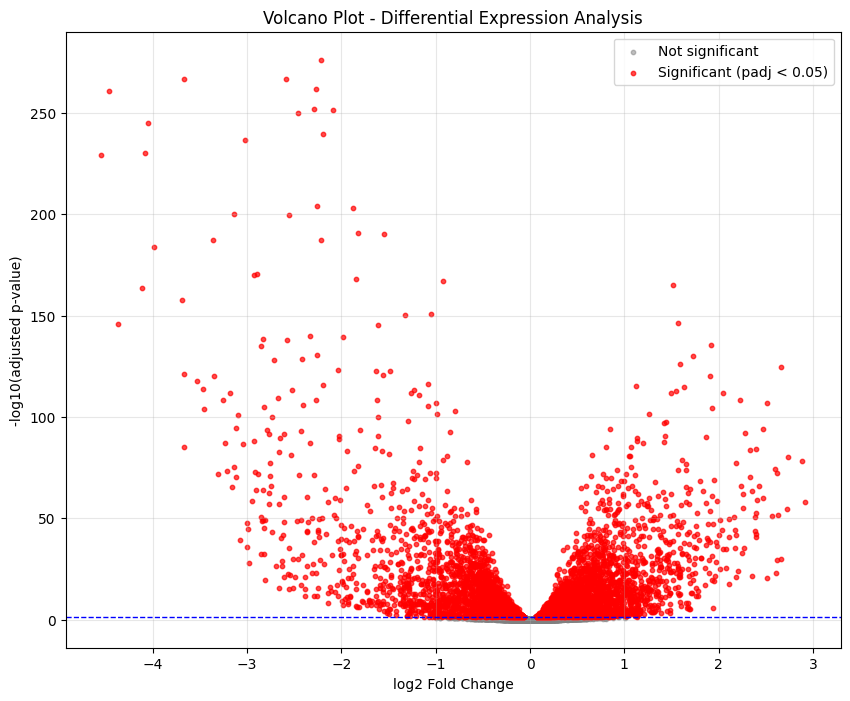

In [35]:
# Optional: Create a volcano plot
try:
    import matplotlib.pyplot as plt
    
    # Prepare data for volcano plot
    plot_data = results_df.copy()
    plot_data['-log10(padj)'] = -np.log10(plot_data['padj'])
    
    # Remove infinite values
    plot_data = plot_data[np.isfinite(plot_data['-log10(padj)'])]
    
    # Create plot
    plt.figure(figsize=(10, 8))
    
    # Non-significant genes
    non_sig = plot_data[plot_data['padj'] >= 0.05]
    plt.scatter(non_sig['log2FoldChange'], non_sig['-log10(padj)'], 
                c='gray', alpha=0.5, s=10, label='Not significant')
    
    # Significant genes
    sig = plot_data[plot_data['padj'] < 0.05]
    plt.scatter(sig['log2FoldChange'], sig['-log10(padj)'], 
                c='red', alpha=0.7, s=10, label='Significant (padj < 0.05)')
    
    plt.xlabel('log2 Fold Change')
    plt.ylabel('-log10(adjusted p-value)')
    plt.title(' Differential Expression Analysis')
    plt.axhline(y=-np.log10(0.05), color='blue', linestyle='--', linewidth=1)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Save plot
    plt.savefig(VOLCANO_PLOT, dpi=300, bbox_inches='tight')
    print(f"Volcano plot saved as: {VOLCANO_PLOT}")
    plt.show()
    
except ImportError:
    print("matplotlib not installed. Skipping visualization.")